# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [51]:
# import libraries

#for data accessing
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine

#Natural language ToolKits
import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Model Selections
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import numpy as np
import time
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df =pd.read_sql_table('DisasterResponse',con=engine)
X = df["message"]
categories=df.columns[4:]
y=df[categories]

In [3]:
y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
genre_counts = df.groupby('genre').count()['message']
genre_names = list(genre_counts.index)

print(genre_names)
print(genre_counts)


['direct', 'news', 'social']
genre
direct    10766
news      13054
social     2396
Name: message, dtype: int64


Text(0,0.5,'Number of Occurence')

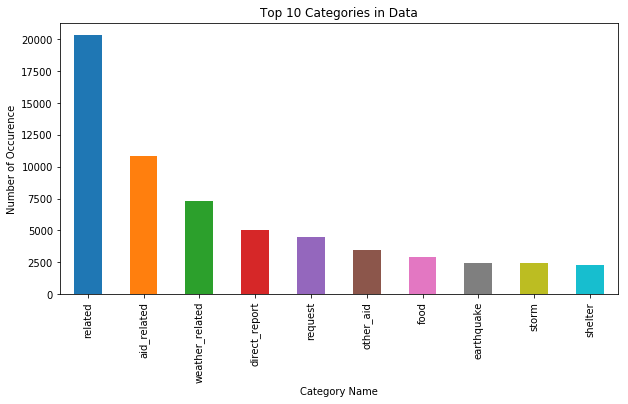

In [63]:
import matplotlib.pyplot as plt

categories_num=df[categories].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
ax=categories_num[:10].plot.bar(x='words', y='counts')
plt.title('Top 10 Categories in Data')
ax.set_xlabel("Category Name")
ax.set_ylabel("Number of Occurence")

### 2. Write a tokenization function to process your text data

In [32]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
        
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    stop_words = stopwords.words('english')
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        if (clean_tok.isalpha() and clean_tok not in stop_words): # filtering our punctuation and stop words        
            clean_tokens.append(clean_tok)
    return clean_tokens

In [34]:
all_words=[]
dicts = {}
for text in X:
    words=tokenize(text)
    all_words.append(words)

all_words=np.hstack(all_words).tolist()
unique_words=set(all_words)
for words in unique_words : 
        dicts[words]=all_words.count(words)


In [35]:
freq_df=pd.DataFrame.from_dict(dicts,orient='index')
freq_df=freq_df.reset_index()

In [36]:
freq_df.rename(columns={"index": "word", 0: "count"},inplace=True)

In [61]:
top10words=freq_df.sort_values(by="count",ascending=False).iloc[:10,:]
top10words

,word,count
26106,people,2997
17249,water,2949
4000,food,2830
25759,help,2631
17060,need,2479
7577,ha,2425
8673,please,1997
8356,earthquake,1865
26207,area,1642
1656,wa,1601


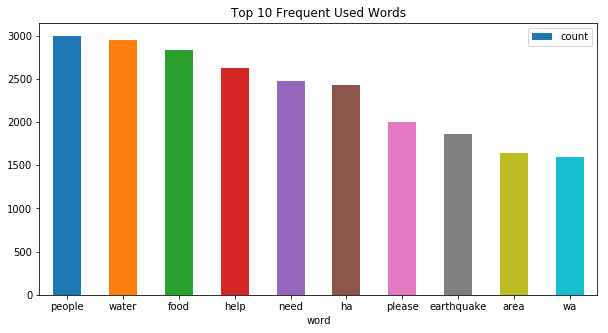

In [62]:
ax = top10words.plot.bar(x='word', y='count', rot=0, figsize=(10,5),title="Top 10 Frequent Used Words")

In [43]:
stopwords.words('english')
tokenize("I am going to work")

['going', 'work']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [24]:
pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=-1)))
            ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [25]:
start = time.process_time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline.fit(X_train, y_train)
print(time.process_time() - start)

86.98063748999994


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [8]:

report=[]
f1_scores=[]
for i,col in enumerate(y_test.columns):    
    y_pred= pipeline.predict(X_test)
    y_true=y_test[col]
    #f=classification_report(y_true, y_pred[:,i])
    score=f1_score(y_true, y_pred[:,i], average='weighted')
    report.append(f)
    f1_scores.append(score)

avg_f1 = np.mean(f1_scores)
print("Avg weighted f1-score:{}".format(avg_f1))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg weighted f1-score:0.9354452341398327


In [26]:
pipeline.get_params() # see the model parameters

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f1b0a1b9a60>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
               oob_score=False, random_state=None

### 6. Improve your model
Use grid search to find better parameters. 

In [27]:
parameters = {'clf__estimator__n_estimators': [10],
                  'clf__estimator__max_features': ['log2', 'sqrt', 'auto'],
                  'clf__estimator__criterion': ['entropy', 'gini'],
                  'clf__estimator__max_depth': [2, 3, 5, 10],
                  'clf__estimator__min_samples_split': [2, 3, 5],
                  'clf__estimator__min_samples_leaf': [1, 5, 8]}

cv = GridSearchCV(pipeline, param_grid=parameters,n_jobs=-1)

In [64]:
import time
start = time.process_time()
cv.fit(X_train, y_train)
print(time.process_time() - start)

7.61009999905582e-05


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [16]:
report=[]
f1_scores=[]
for i,col in enumerate(y.columns):    
    y_pred= cv.predict(X_test)
    y_true=y_test[col]
    f=classification_report(y_true, y_pred[:,i])
    score=f1_score(y_true, y_pred[:,i], average='weighted')
    report.append(f)
    f1_scores.append(score)

avg_f1 = np.mean(f1_scores)
print("Avg weighted f1-score:{}".format(avg_f1))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg weighted f1-score:0.9320551632748013


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [8]:
class Text_Length_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(lambda x: len(x)).values
        return pd.DataFrame(X_tagged)   


In [9]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('text_len', Text_Length_Extractor())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'text_len': 0.5},
            {'text_pipeline': 0.5, 'text_len': 1},
            {'text_pipeline': 0.8, 'text_len': 1},
        )
    }

    model = GridSearchCV(pipeline, param_grid=parameters)
    return model

In [66]:
build_model().estimator.get_params()

### 9. Export your model as a pickle file

In [17]:
import pickle
# Save to file in the current working directory
with open(classifier.pkl, 'wb') as file:
    pickle.dump(cv, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.